<a href="https://colab.research.google.com/github/jpafcampos/VAE_dogs/blob/main/vae_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
from torch import nn
import os, random
import collections
import torch
import torchvision
import numpy as np
from torch.utils import data
import torchvision
import torchvision.transforms as T
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from skimage.io import imread
from skimage.transform import resize, rescale
import skimage.transform as scikit_transform
import scipy
import skimage as ski

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image

from torch.optim import lr_scheduler


In [4]:
%cd /content/drive/MyDrive/dog_breeds

/content/drive/MyDrive/dog_breeds


In [5]:
class DogsDataset(data.Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].to_numpy().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [6]:

#Read the dataset 
PATH = '/content/drive/MyDrive/dog_breeds/'
labels = pd.read_csv(PATH+'labels.csv')
labelnames = pd.read_csv(PATH + 'sample_submission.csv').keys()[1:]
print("Train folder has ", len(os.listdir(PATH+'train')),'images which matches with label\'s', len(labels),'images')

Train folder has  10222 images which matches with label's 10222 images


In [7]:
codes = range(len(labelnames))
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
labels['target'] =  [breed_to_code[x] for x in labels.breed]
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.85)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(8689, 121) (1533, 121)


In [220]:
BATCH_SIZE = 64

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(128),
                               transforms.CenterCrop(128),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, PATH+'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, PATH+'train/', transform=ds_trans)

train_dl = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_dl = data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [212]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([16, 3, 128, 128]) torch.Size([16])


IndexError: ignored

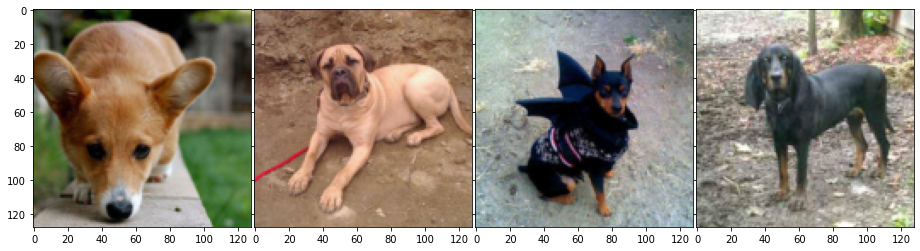

In [213]:
img, label = next(iter(train_dl))
#print(label)
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [168]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32, kernel_size=3, stride=2, padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,32, kernel_size=3,stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(8*8*32, 512)
        self.fc1 = nn.Linear(512 , latent_dims)
        self.fc2 = nn.Linear(512 , latent_dims)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.relu(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.relu(x)
        w_mean = self.fc1(x)
        w_std  = self.fc2(x)
        return w_mean, w_std

In [176]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(latent_dims, 500)
        self.fc2 = nn.Linear(500, 8*8*32)
        self.deconv1 = nn.ConvTranspose2d(32,64, kernel_size=3, stride =2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32, kernel_size=3, stride =2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32,16, kernel_size=3, stride =2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(16,3, kernel_size=3, stride =2, padding=1, output_padding=1)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)

    def forward(self, z):
        x = self.fc1(z)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)

        x = x.view(-1,32,8,8)
        x = self.deconv1(x)
        x = self.relu(x)
        x = self.deconv2(x)
        x = self.relu(x)
        x = self.deconv3(x)
        x = self.relu(x)
        x = self.deconv4(x)
        x = self.sigmoid(x)
        return x

In [177]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, is_cuda = True):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        self.is_cuda = is_cuda

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if self.is_cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()

        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        res = self.decoder(z)
        return res, mu, logvar

In [178]:
reconstruction_function = nn.MSELoss()
reconstruction_function.size_average = False
def loss_function(recon_x, x, mu, logvar):

    MSE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

In [221]:
LR = 1e-4
EPOCH = 20
LOG_INTERVAL = 400
model = VariationalAutoencoder(512)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [222]:
optimizer = optim.Adam(model.parameters(), lr=LR)

In [223]:
def unnormalize(y, mean, std):
    x = y.new(*y.size())
    x[:, 0, :, :] = y[:, 0, :, :] * std[0] + mean[0]
    x[:, 1, :, :] = y[:, 1, :, :] * std[1] + mean[1]
    x[:, 2, :, :] = y[:, 2, :, :] * std[2] + mean[2]
    return x

In [224]:
from tqdm import tqdm
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def train_step(epoch):

    model.train()
    train_loss = 0
    batch_idx = 1
    for data in tqdm(train_dl):
        # get the inputs
        inputs, _ = data

        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(inputs)
        #print(inputs.data.size())
        inputs = unnormalize(inputs, mean, std)

        #print("input max/min"+str(inputs.max())+"  "+str(inputs.min()))
        #print("recon input max/min"+str(recon_batch.max())+"  "+str(recon_batch.min()))
        loss = loss_function(recon_batch, inputs, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), (len(train_dl)*128),
                100. * batch_idx / len(train_dl),
                loss.item() / len(inputs)))
        batch_idx+=1

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / (len(train_dl)*BATCH_SIZE)))
    return train_loss / (len(train_dl)*BATCH_SIZE)

In [227]:
def test_step(epoch):
    model.eval()
    test_loss = 0
    print("iniciando val")
    for data in tqdm(valid_dl):
        # get the inputs
        inputs, _ = data

        inputs = inputs.to(device)
    
        recon_batch, mu, logvar = model(inputs)
        inputs = unnormalize(inputs, mean, std)
        test_loss += loss_function(recon_batch, inputs, mu, logvar).item()
        if((epoch+1)%5==0):
            torchvision.utils.save_image(inputs, './imgs/Epoch_{}_data.jpg'.format(epoch), nrow=8, padding=8)
            torchvision.utils.save_image(recon_batch, './imgs/Epoch_{}_recon.jpg'.format(epoch), nrow=8, padding=8)

    test_loss /= (len(valid_dl)*128)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [228]:
for epoch in range(EPOCH):
    train_loss = train_step(epoch)
    test_loss = test_step(epoch)
    torch.save(model.state_dict(), './models/Epoch_{}_Train_loss_{:.4f}_Test_loss_{:.4f}.pth'.format(epoch, train_loss, test_loss))
 
print('Training complete')

100%|██████████| 136/136 [00:41<00:00,  3.31it/s]


====> Epoch: 0 Average loss: 0.0242
iniciando val


100%|██████████| 24/24 [00:07<00:00,  3.16it/s]


====> Test set loss: 0.0066


100%|██████████| 136/136 [00:42<00:00,  3.19it/s]


====> Epoch: 1 Average loss: 0.0084
iniciando val


100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


====> Test set loss: 0.0035


100%|██████████| 136/136 [00:41<00:00,  3.29it/s]


====> Epoch: 2 Average loss: 0.0048
iniciando val


100%|██████████| 24/24 [00:07<00:00,  3.25it/s]


====> Test set loss: 0.0024


100%|██████████| 136/136 [00:42<00:00,  3.20it/s]


====> Epoch: 3 Average loss: 0.0035
iniciando val


100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


====> Test set loss: 0.0018


100%|██████████| 136/136 [00:41<00:00,  3.31it/s]


====> Epoch: 4 Average loss: 0.0027
iniciando val


100%|██████████| 24/24 [00:09<00:00,  2.45it/s]


====> Test set loss: 0.0015


100%|██████████| 136/136 [00:42<00:00,  3.20it/s]


====> Epoch: 5 Average loss: 0.0023
iniciando val


100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


====> Test set loss: 0.0013


100%|██████████| 136/136 [00:40<00:00,  3.32it/s]


====> Epoch: 6 Average loss: 0.0020
iniciando val


100%|██████████| 24/24 [00:07<00:00,  3.24it/s]


====> Test set loss: 0.0012


100%|██████████| 136/136 [00:42<00:00,  3.19it/s]


====> Epoch: 7 Average loss: 0.0018
iniciando val


100%|██████████| 24/24 [00:07<00:00,  3.17it/s]


====> Test set loss: 0.0010


100%|██████████| 136/136 [00:43<00:00,  3.16it/s]


====> Epoch: 8 Average loss: 0.0016
iniciando val


100%|██████████| 24/24 [00:07<00:00,  3.28it/s]


====> Test set loss: 0.0009


  6%|▌         | 8/136 [00:02<00:45,  2.79it/s]


KeyboardInterrupt: ignored

In [175]:
y[0].shape

torch.Size([4, 3, 128, 128])

In [ ]:
#https://github.com/podgorskiy/VAE

#https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py

#https://github.com/CaptainDredge/Variational-AutoEncoder-in-Pytorch/blob/master/vae.py

#https://www.kaggle.com/code/speedwagon/variational-autoencoder-dogs-generation <3

In [192]:
%ls

dog-breed-identification.zip  labels.gsheet          sample_submission.gsheet
imgs/                         ls/                    test/
labels.csv                    sample_submission.csv  train/


In [193]:
%mkdir models